In [1]:
!pip install --quiet vit-keras
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 10.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#please set title for saving model correctly!!!
title = "seb_vs_nev_with_aug"

#Using our merged dataset train & test data

This Task is (SEB VS NEVUS)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import pandas as pd
import numpy as np
import keras
from keras import backend as K

import tensorflow
from tensorflow.keras.layers import Dropout, Dense, LayerNormalization, Flatten
from tensorflow.keras.activations import gelu
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from vit_keras import vit
import tensorflow_addons as tfa
import math

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt

from zipfile import ZipFile
import time
from sklearn.model_selection import StratifiedKFold, KFold

from sklearn.metrics import roc_auc_score
from sklearn.metrics import  precision_score, recall_score, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import backend as K

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [5]:
#Initializing ViT model
vit_model = vit.vit_b16(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 2)

347502902/347502902 [==============================] - 4s 0us/step


/usr/local/lib/python3.10/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [6]:
#Adding additional layer to ViT 
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(2, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Batc  (None, 11)               44        
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 2)          

In [7]:
#Function for focal loss
def focal_loss(gamma=2.0, alpha=0.7):
    def focal_loss_fn(y_true, y_pred):
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        focal_loss = -alpha * y_true * K.pow(1.0 - y_pred, gamma) * K.log(y_pred)
        return K.mean(focal_loss, axis=-1)
    return focal_loss_fn

# compiling model using adam optimizer and focal loss
model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

In [8]:
early_stopping = EarlyStopping(monitor='val_loss',patience=2)               #Configuring Early stopping criteria

def step_decay(epoch):
    initial_lrate = 0.00002                                                 #Configuring learning rate
    drop = 0.1
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(step_decay, verbose=1)

In [9]:
#function for plotting train and validation accuracy and loss
def graph_it(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Model Accuracy: Training and Validation')
  plt.legend(loc=0)
  plt.figure()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation Loss')
  plt.legend(loc=0)
  plt.figure()


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report, precision_score, roc_curve, ConfusionMatrixDisplay

def test_it(model, test_generator):
    test_labels = test_generator.classes

    predictions = model.predict(test_generator)
    predicted_labels = np.argmax(predictions, axis=1)

    cm = confusion_matrix(test_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

    roc = roc_auc_score(test_labels, predictions[:, 1])  # ROC score calculation

    # Calculate confusion matrix 
    tn, fp, fn, tp = confusion_matrix(test_labels, predicted_labels).ravel()

    # Calculate sensitivity and specificity
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)

    report = classification_report(test_labels, predicted_labels)  #classification report

    precision = precision_score(test_labels, predicted_labels, average='weighted') #calculating precision score

    print("\n", report)
    print(f"Sensitivity: {round(sensitivity, 3)} Specificity: {round(specificity, 3)} Precision: {round(precision, 3)} ROC_AUC_SCORE: {round(roc, 3)}\n")

    # Plot AUC-ROC curve
    fpr, tpr, thresholds = roc_curve(test_labels, predictions[:, 1])
    plt.figure(figsize=(4, 4))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

In [11]:
# Set the directories for the data for task1 (SEB VS NEVUS)
train_dir = "/content/drive/MyDrive/msc_project/train_splited_augumented"
test_dir = "/content/drive/MyDrive/msc_project/test_splited"

In [12]:
# Combine the paths and corresponding labels for the stratified k-fold
train_paths = []
train_labels = []
for class_folder in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_folder)
    if os.path.isdir(class_path):
        class_label = class_folder
        for image_filename in os.listdir(class_path):
            train_paths.append(os.path.join(class_path, image_filename))
            train_labels.append(class_label)

train_paths = np.array(train_paths)
train_labels = np.array(train_labels)

In [13]:
# Define the data generator
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

image_size = (224, 224)
batch = 10
num_fold = 5

# Initialize the stratified k-fold object
skf = StratifiedKFold(n_splits=num_fold, shuffle=True, random_state=None)

In [14]:
model_path = f'/content/drive/MyDrive/msc_project/model/{title}'
os.makedirs(model_path, exist_ok=True)

Traning for Fold: 1
Found 7810 validated image filenames belonging to 2 classes.
Found 1953 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.1541 - accuracy: 0.5696 
Epoch 1: val_accuracy improved from -inf to 0.69000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_aug/model_fold_1_batch_norm.hdf5
79/79 [==============================] - 1354s 17s/step - loss: 0.1541 - accuracy: 0.5696 - val_loss: 0.0864 - val_accuracy: 0.6900 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.0996 - accuracy: 0.6177 
Epoch 2: val_accuracy did not improve from 0.69000
79/79 [==============================] - 1370s 17s/step - loss: 0.0996 - accuracy: 0.6177 - val_loss: 0.0818 - val_accuracy: 0.6550 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setti

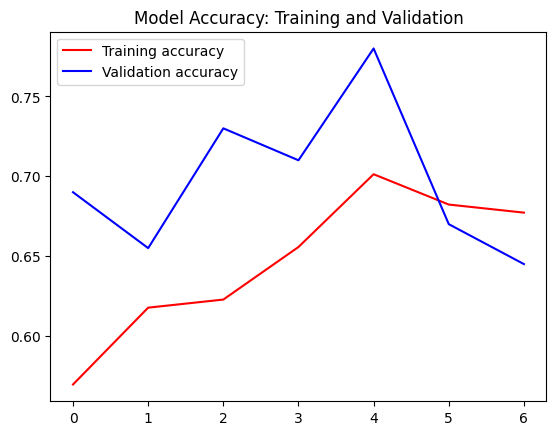

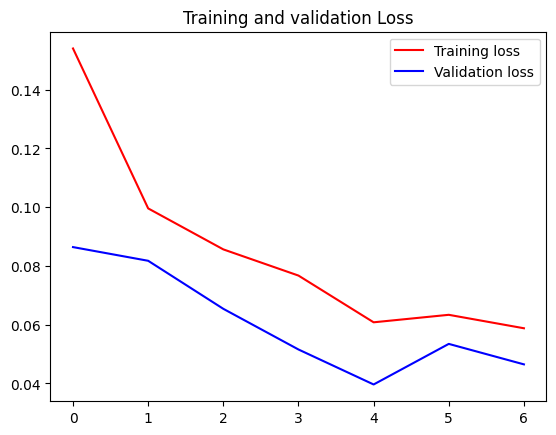

<Figure size 640x480 with 0 Axes>

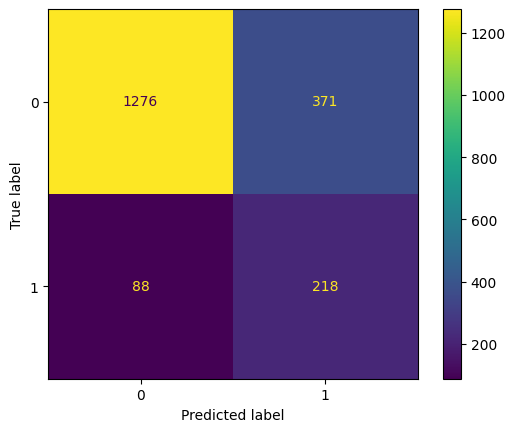


               precision    recall  f1-score   support

           0       0.94      0.77      0.85      1647
           1       0.37      0.71      0.49       306

    accuracy                           0.76      1953
   macro avg       0.65      0.74      0.67      1953
weighted avg       0.85      0.76      0.79      1953

Sensitivity: 0.712 Specificity: 0.775 Precision: 0.847 ROC_AUC_SCORE: 0.851



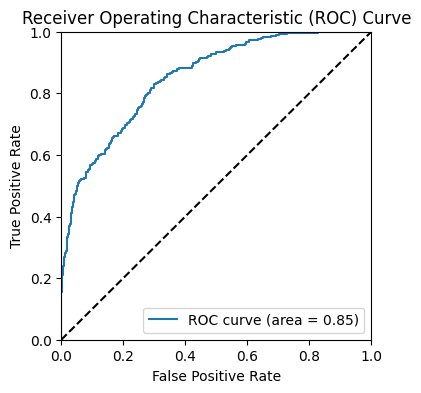

Validation complete...
Traning for Fold: 2
Found 7810 validated image filenames belonging to 2 classes.
Found 1953 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.0640 - accuracy: 0.6291 
Epoch 1: val_accuracy improved from -inf to 0.48000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_aug/model_fold_2_batch_norm.hdf5
79/79 [==============================] - 1381s 17s/step - loss: 0.0640 - accuracy: 0.6291 - val_loss: 0.0637 - val_accuracy: 0.4800 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.0558 - accuracy: 0.6595 
Epoch 2: val_accuracy improved from 0.48000 to 0.63000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_aug/model_fold_2_batch_norm.hdf5
79/79 [==============================] - 1314s 17s/step -

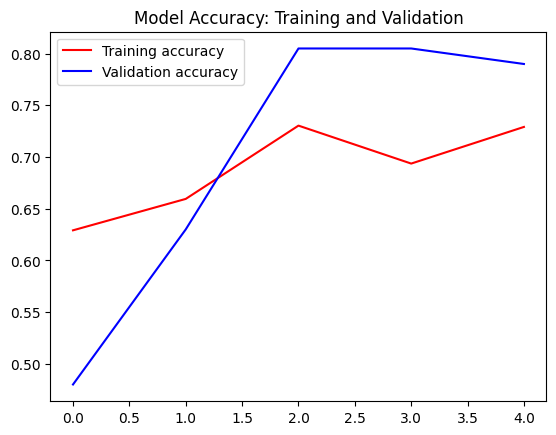

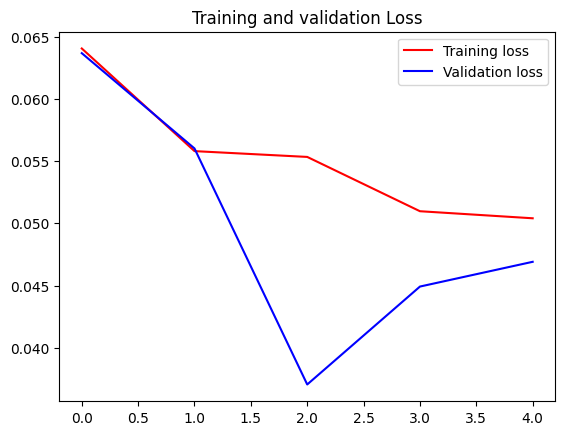

<Figure size 640x480 with 0 Axes>

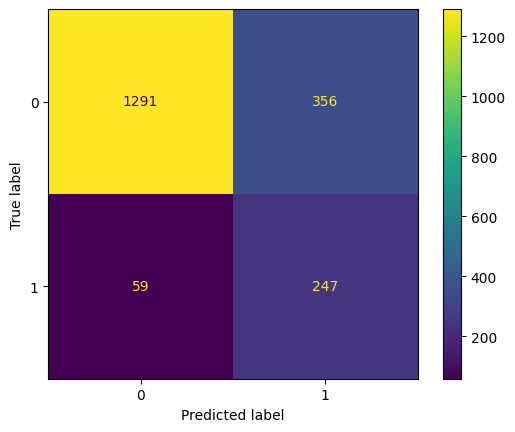


               precision    recall  f1-score   support

           0       0.96      0.78      0.86      1647
           1       0.41      0.81      0.54       306

    accuracy                           0.79      1953
   macro avg       0.68      0.80      0.70      1953
weighted avg       0.87      0.79      0.81      1953

Sensitivity: 0.807 Specificity: 0.784 Precision: 0.871 ROC_AUC_SCORE: 0.891



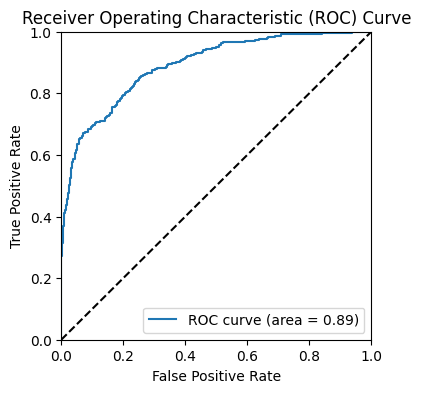

Validation complete...
Traning for Fold: 3
Found 7810 validated image filenames belonging to 2 classes.
Found 1953 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.0573 - accuracy: 0.7228 
Epoch 1: val_accuracy improved from -inf to 0.69000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_aug/model_fold_3_batch_norm.hdf5
79/79 [==============================] - 1329s 17s/step - loss: 0.0573 - accuracy: 0.7228 - val_loss: 0.0476 - val_accuracy: 0.6900 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.0524 - accuracy: 0.7089 
Epoch 2: val_accuracy improved from 0.69000 to 0.80500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_aug/model_fold_3_batch_norm.hdf5
79/79 [==============================] - 1358s 17s/step -

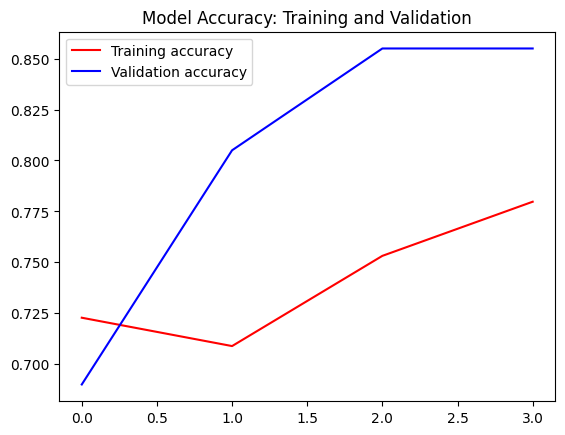

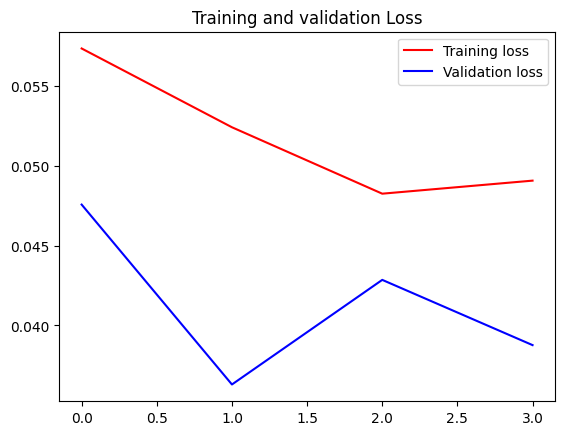

<Figure size 640x480 with 0 Axes>

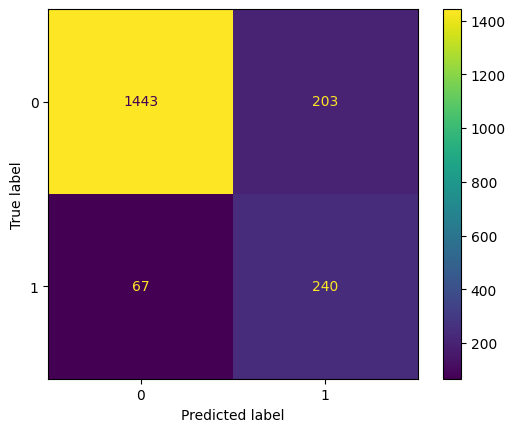


               precision    recall  f1-score   support

           0       0.96      0.88      0.91      1646
           1       0.54      0.78      0.64       307

    accuracy                           0.86      1953
   macro avg       0.75      0.83      0.78      1953
weighted avg       0.89      0.86      0.87      1953

Sensitivity: 0.782 Specificity: 0.877 Precision: 0.891 ROC_AUC_SCORE: 0.916



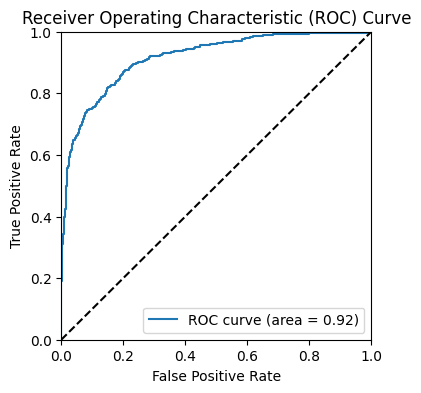

Validation complete...
Traning for Fold: 4
Found 7811 validated image filenames belonging to 2 classes.
Found 1952 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.7114 
Epoch 1: val_accuracy improved from -inf to 0.86500, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_aug/model_fold_4_batch_norm.hdf5
79/79 [==============================] - 1388s 17s/step - loss: 0.0541 - accuracy: 0.7114 - val_loss: 0.0376 - val_accuracy: 0.8650 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.0438 - accuracy: 0.7849 
Epoch 2: val_accuracy improved from 0.86500 to 0.91000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_aug/model_fold_4_batch_norm.hdf5
79/79 [==============================] - 1300s 16s/step -

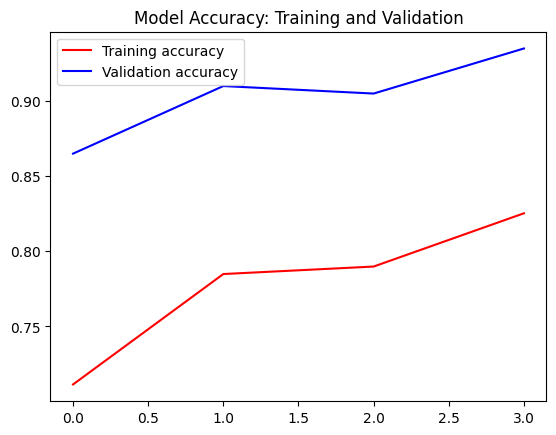

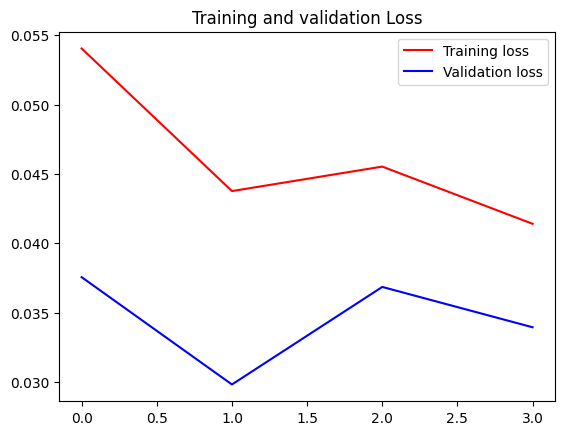

<Figure size 640x480 with 0 Axes>

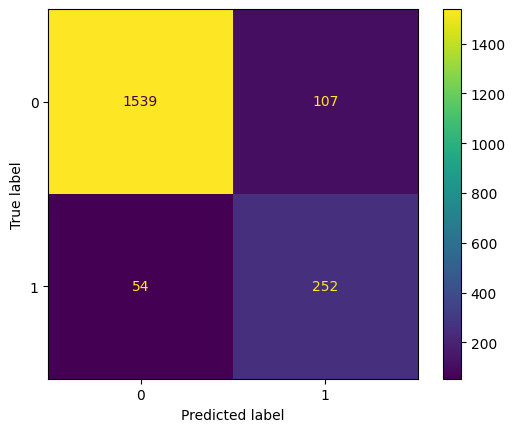


               precision    recall  f1-score   support

           0       0.97      0.93      0.95      1646
           1       0.70      0.82      0.76       306

    accuracy                           0.92      1952
   macro avg       0.83      0.88      0.85      1952
weighted avg       0.92      0.92      0.92      1952

Sensitivity: 0.824 Specificity: 0.935 Precision: 0.925 ROC_AUC_SCORE: 0.944



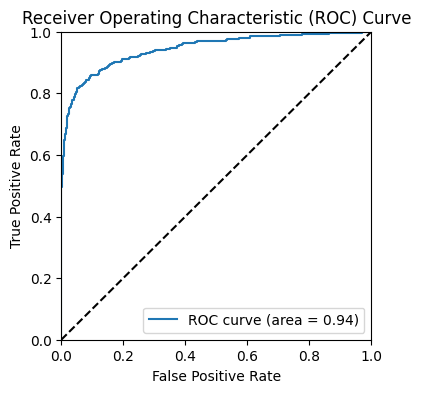

Validation complete...
Traning for Fold: 5
Found 7811 validated image filenames belonging to 2 classes.
Found 1952 validated image filenames belonging to 2 classes.

Epoch 1: LearningRateScheduler setting learning rate to 2e-05.
Epoch 1/30
79/79 [==============================] - ETA: 0s - loss: 0.0430 - accuracy: 0.8316 
Epoch 1: val_accuracy improved from -inf to 0.94000, saving model to /content/drive/MyDrive/msc_project/model/seb_vs_nev_aug/model_fold_5_batch_norm.hdf5
79/79 [==============================] - 1352s 17s/step - loss: 0.0430 - accuracy: 0.8316 - val_loss: 0.0284 - val_accuracy: 0.9400 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 2e-05.
Epoch 2/30
79/79 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.8367 
Epoch 2: val_accuracy did not improve from 0.94000
79/79 [==============================] - 1358s 17s/step - loss: 0.0389 - accuracy: 0.8367 - val_loss: 0.0349 - val_accuracy: 0.8800 - lr: 2.0000e-05

Epoch 3: Lear

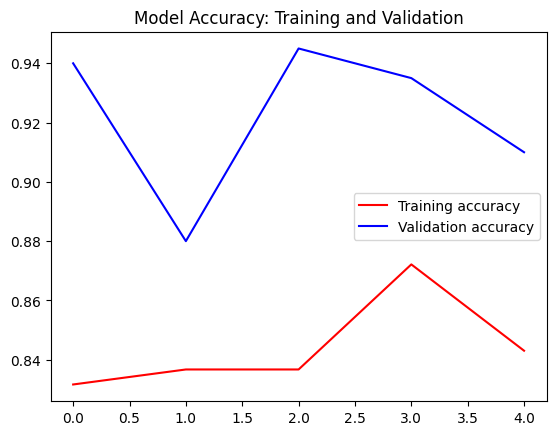

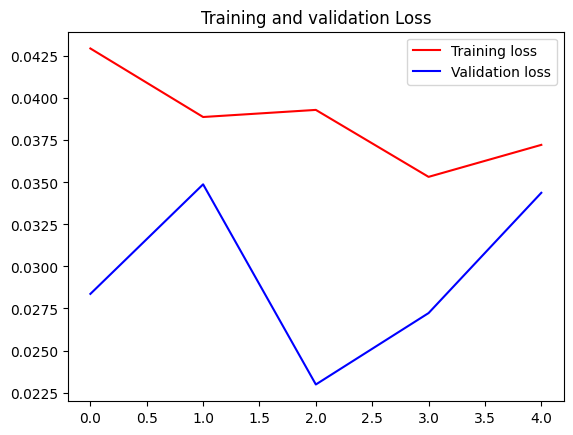

<Figure size 640x480 with 0 Axes>

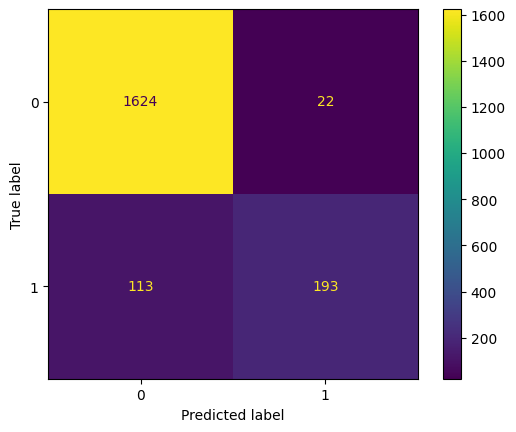


               precision    recall  f1-score   support

           0       0.93      0.99      0.96      1646
           1       0.90      0.63      0.74       306

    accuracy                           0.93      1952
   macro avg       0.92      0.81      0.85      1952
weighted avg       0.93      0.93      0.93      1952

Sensitivity: 0.631 Specificity: 0.987 Precision: 0.929 ROC_AUC_SCORE: 0.905



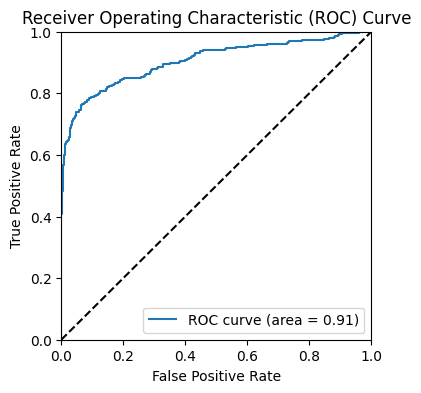

Validation complete...


In [15]:
# Perform k-fold cross-validation
fold = 1
for i, (train_index, val_index) in enumerate(skf.split(train_paths, train_labels)):
    print(f"Traning for Fold: {fold}")
    # Split the data into train and validation sets for this fold
    train_paths_fold, val_paths_fold = train_paths[train_index], train_paths[val_index]
    train_labels_fold, val_labels_fold = train_labels[train_index], train_labels[val_index]

    # Create data generators for this fold
    train_generator_fold = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': train_paths_fold, 'class': train_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch
    )

    val_generator_fold = datagen.flow_from_dataframe(
      pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
      directory=train_dir,
      x_col='filename',
      y_col='class',
      target_size=image_size,
      batch_size=batch
  )

    train_steps = np.ceil(len(train_generator_fold) / batch)
    val_steps = np.ceil(len(val_generator_fold) / batch)

    #set path to save model
    checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = model_path + f'/model_fold_{fold}_batch_norm.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

    callbacks = [early_stopping, checkpointer, lr_scheduler]


    # Compile the model
    model.compile(optimizer='adam', loss=focal_loss(), metrics=['accuracy'])

    # Train the model on the training data and evaluate on the validation data
    history = model.fit(
        train_generator_fold,
        steps_per_epoch=train_steps,
        validation_data=val_generator_fold,
        validation_steps=val_steps,
        epochs=30,
        callbacks=callbacks)

    #plot train and validation accuracy and loss
    graph_it(history)


    val_generator_fold_test = datagen.flow_from_dataframe(
        pd.DataFrame({'filename': val_paths_fold, 'class': val_labels_fold}),
        directory=train_dir,
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )

    print(f"\nValidating for fold {fold}... \n")
    print("Loading model...")

    model.load_weights(filepath = model_path + f'/model_fold_{fold}_batch_norm.hdf5')
    test_it(model, val_generator_fold_test)

    print("Validation complete...")

    fold += 1


**Model Evaluation using test data**

In [16]:
test_dir

'/content/drive/MyDrive/msc_project/test_splited'

In [17]:
test_generator = datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=1,
        shuffle=False
    )
test_generator.shuffle = False

Found 483 images belonging to 2 classes.


Test using model 1
483/483 [==============================] - 256s 530ms/step


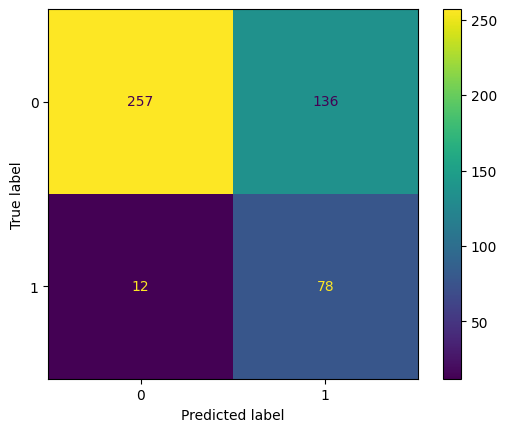


               precision    recall  f1-score   support

           0       0.96      0.65      0.78       393
           1       0.36      0.87      0.51        90

    accuracy                           0.69       483
   macro avg       0.66      0.76      0.64       483
weighted avg       0.85      0.69      0.73       483

Sensitivity: 0.867 Specificity: 0.654 Precision: 0.845 ROC_AUC_SCORE: 0.862



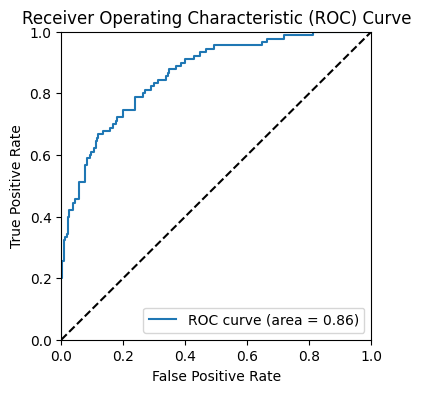

Testing Complete
Test using model 2
483/483 [==============================] - 256s 530ms/step


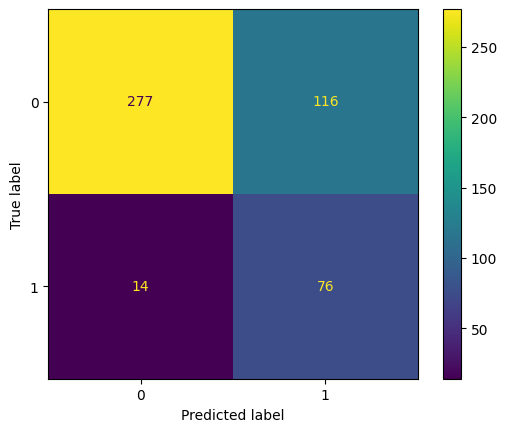


               precision    recall  f1-score   support

           0       0.95      0.70      0.81       393
           1       0.40      0.84      0.54        90

    accuracy                           0.73       483
   macro avg       0.67      0.77      0.67       483
weighted avg       0.85      0.73      0.76       483

Sensitivity: 0.844 Specificity: 0.705 Precision: 0.848 ROC_AUC_SCORE: 0.866



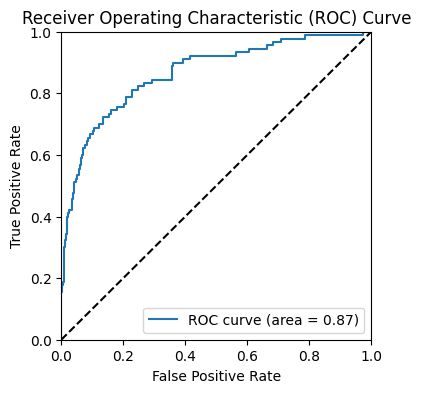

Testing Complete
Test using model 3
483/483 [==============================] - 255s 527ms/step


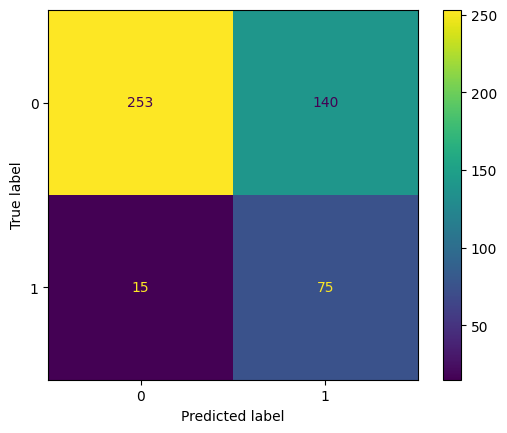


               precision    recall  f1-score   support

           0       0.94      0.64      0.77       393
           1       0.35      0.83      0.49        90

    accuracy                           0.68       483
   macro avg       0.65      0.74      0.63       483
weighted avg       0.83      0.68      0.71       483

Sensitivity: 0.833 Specificity: 0.644 Precision: 0.833 ROC_AUC_SCORE: 0.843



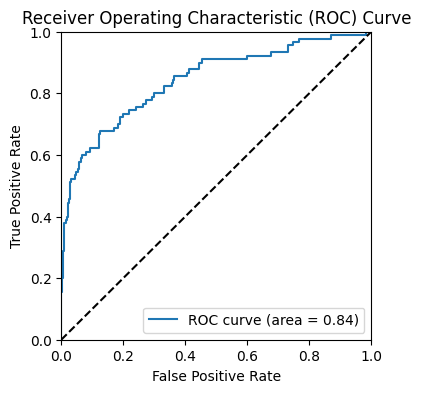

Testing Complete
Test using model 4
483/483 [==============================] - 256s 531ms/step


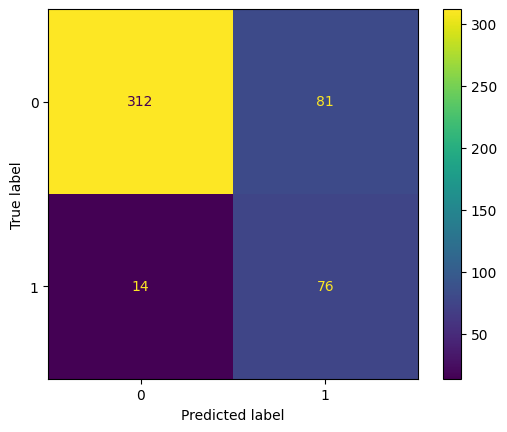


               precision    recall  f1-score   support

           0       0.96      0.79      0.87       393
           1       0.48      0.84      0.62        90

    accuracy                           0.80       483
   macro avg       0.72      0.82      0.74       483
weighted avg       0.87      0.80      0.82       483

Sensitivity: 0.844 Specificity: 0.794 Precision: 0.869 ROC_AUC_SCORE: 0.915



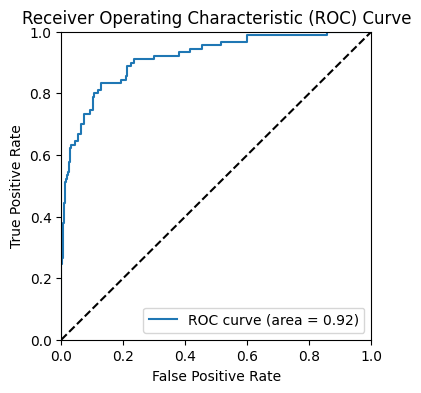

Testing Complete
Test using model 5
483/483 [==============================] - 257s 533ms/step


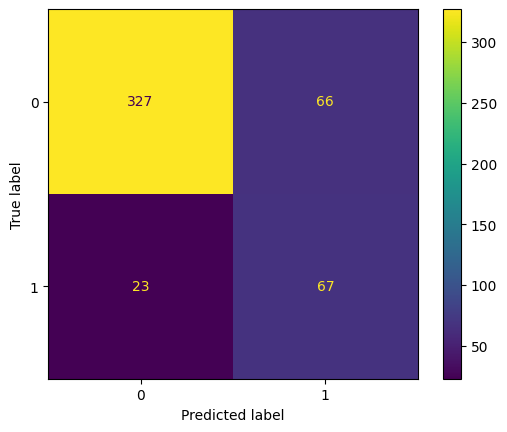


               precision    recall  f1-score   support

           0       0.93      0.83      0.88       393
           1       0.50      0.74      0.60        90

    accuracy                           0.82       483
   macro avg       0.72      0.79      0.74       483
weighted avg       0.85      0.82      0.83       483

Sensitivity: 0.744 Specificity: 0.832 Precision: 0.854 ROC_AUC_SCORE: 0.833



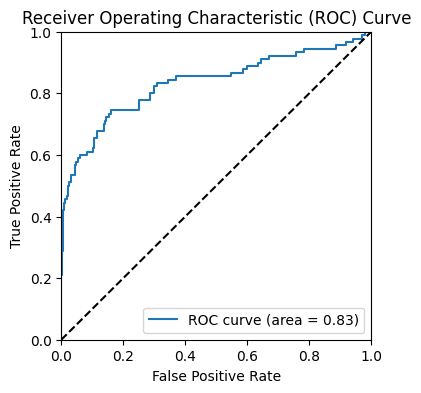

Testing Complete


In [18]:
#set path to best weights from your training please manually! {title}_fold_{fold}
for i in range(1, num_fold+1):
  print(f"Test using model {i}")
  model.load_weights(filepath = model_path + f'/model_fold_{i}_batch_norm.hdf5')
  test_it(model, test_generator)
  print("Testing Complete")